# DoorHinge joint inspector
The `DoorHinge` class is a `ForceElement`, which models a revolute door hinge joint that could exhibits different force/torque characterisitcs at different states due to the existence of different type of torques on the joint. This class implements a "christmas tree" accumulation of these different torques (i.e. function approximation) in an empirical and unprincipled way. Specifically, different curves are assigned to different torques to mimic their evolution based on the joint state and some prespecified parameters. More details can be referred to the doxygen documentation of the `DoorHinge` class.


This tutorial provides a small tool to allow you to play with the `DoorHingeConfig` parameter and visualize the properties of a particular setup. It could facilitate you get the specifc kind of door hinge joint behavior you are interested. In this tutorial, we provide a common dishwasher door modeling as an example.

A common dishwasher door has a frictional torque sufficient for it to rest motionless at any angle, a catch at the top to hold it in place, a dashpot (viscous friction source) to prevent it from swinging too fast, and a spring to counteract some of its mass. The following two figures illustrate the dishwasher door hinge torque with the given default parameters. We first used a force gauge to estimate these values roughly. Then we simulate the dishwasher door for minor adjustment.

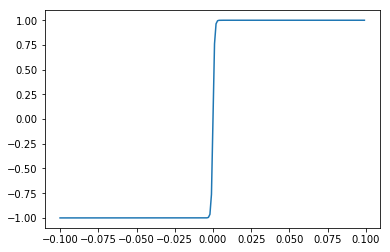

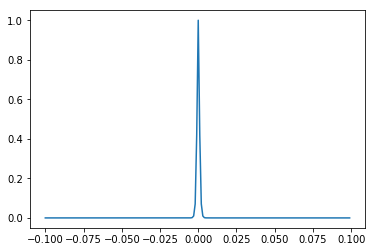

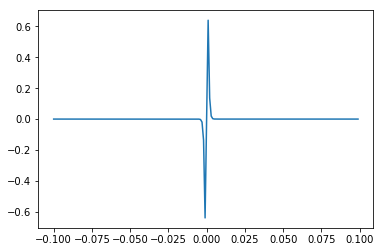

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# A simple function to plot lambda functions
def graph(formula, x, parameters):  
    y = formula(x, parameters)
    plt.plot(x,y)  
    plt.show() 

# These functions are predefined in the DoorHinge class. The users should not modify them.
# Curv functions
sigmoid_fn = lambda x, threshold: np.tanh(x / threshold)
graph(sigmoid_fn, np.arange(-0.1, 0.1, 0.001), 0.001)

singlet_fn = lambda x, threshold: 1 - sigmoid_fn(x, threshold) ** 2
graph(singlet_fn, np.arange(-0.1, 0.1, 0.001), 0.001)

doublet_fn = lambda x, threshold: np.multiply(np.dot(2, sigmoid_fn(x, threshold)), singlet_fn(x, threshold))
graph(doublet_fn, np.arange(-0.1, 0.1, 0.001), 0.001)

# Torque functions
# Friction torque functions which are velocity dependent.
dynamic_friction_torque_fn = lambda v, config : np.multiply(-config.dynamic_friction_torque, sigmoid_fn(v, config.motion_threshold))
static_friction_torque_fn = lambda v, config : np.multiply(-config.static_friction_torque, doublet_fn(v, config.motion_threshold))
viscous_torque_fn = lambda v, config : np.multiply(-v, config.viscous_friction)
hinge_friction_torque_fn= lambda v, config : dynamic_friction_torque_fn(v, config) + static_friction_torque_fn(v, config) + viscous_torque_fn(v, config)

# Spring torque functions which are position dependent.
catch_torque_fn = lambda q, config : np.multiply(doublet_fn(q - config.catch_width, config.catch_width),config.catch_torque)
spring_torque_fn = lambda q, config : np.multiply(-(q - config.spring_zero_angle_rad), config.spring_constant)
hinge_spring_torque_fn= lambda q, config : catch_torque_fn(q, config) + spring_torque_fn(q, config)

# Total external torque exerted on the door hinge joint except the gravity (if there is any).
total_torque_fn=lambda q,v,config: hinge_friction_torque_fn(v,config) + hinge_spring_torque_fn(q,config)


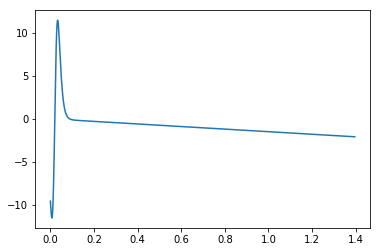

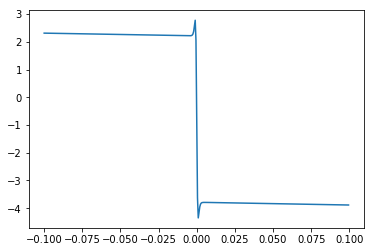

In [29]:
# Parameters that user can change to investigate the torque characteristics
# Config parameters
# TODO(huihua) Replace this workaround with the actual DoorHingeConfig after adding the DoorHinge class to pydrake.
from typing import NamedTuple

class DoorHingeConfig(NamedTuple):
    spring_zero_angle_rad: float = 0.0
    spring_constant: float = 1.5
    dynamic_friction_torque: float = 3.0
    static_friction_torque: float = 2.0
    viscous_friction: float = 1.0
    catch_width: float = 0.02
    catch_torque: float = 15
    motion_threshold: float = 0.001

# Prepare data to plot
door_hinge_config = DoorHingeConfig()

min_q = 0.0
max_q = np.deg2rad(80)
min_v = -0.1
max_v = 0.1
step_size = 0.0005
q_array = np.arange(min_q, max_q, step_size)
v_array = np.arange(min_v, max_v, step_size)

# Plot the torque over angle at zero velocity
total_torque_at_q_fn = lambda q, config: total_torque_fn(q, 0.0, config)
graph(total_torque_at_q_fn, q_array, door_hinge_config)

# Plot the torque over the angular velocity at 30 degree angle
total_torque_at_v_fn = lambda v, config: total_torque_fn(np.deg2rad(30), v, config)
graph(total_torque_at_v_fn, v_array, door_hinge_config)

The first figure shows the static characteristic of the dishwasher door. At $q = 0$, there exists a negative catch torque to prevent the door from moving. After that, the torsional spring torque will dominate to compensate part of the door gravity. The second figure shows the dynamic feature of the dishwasher door at $q = 30^{∘}$. Whenever the door tries to move, there will be a counter torque to prevent that movement, which therefore keeps the door at rest. Note that, due to the gravity, the dishwasher door will be fully open eventually. However, this process can be really slow because of the default `motion_threshold` is set to be very small.